## Part 1) Choice of Data Source

Let ut use the `human_mitosis` dataset that comes with the [skimage library](https://github.com/scikit-image/scikit-image). It is a uint8 fluorescence microscopy image.

## Part 2) Choice of Frameworks

In this project, a variety of libraries were utilized to address different aspects of data processing, analysis, and visualization. The chosen libraries were selected based on their strengths, compatibility, and relevance to the scientific and computational goals of the project. Below is a comprehensive comparison and justification of the frameworks used, highlighting their role, benefits, drawbacks, and how they interact.

For general-purpose numerical and tabular data manipulation, NumPy and Pandas were employed. NumPy provided a highly optimized foundation for numerical computations, essential for handling large datasets efficiently. Its seamless integration with other libraries made it indispensable for this workflow. Pandas complemented NumPy by offering an intuitive interface for handling tabular data, which facilitated preprocessing and organization tasks. Although Pandas can be computationally intensive for very large datasets, it was chosen for its ease of use and ability to interface with other libraries in the pipeline.

The image processing and segmentation tasks were handled by scikit-image and StarDist. Scikit-image was preferred over OpenCV for its Pythonic API and focus on scientific applications. While OpenCV is highly efficient for real-time image processing, scikit-image offers a richer set of tools for segmentation and feature extraction, making it more suitable for scientific workflows. StarDist was employed for advanced segmentation tasks, leveraging its deep learning capabilities to detect star-convex objects, such as cell nuclei, with high accuracy. This combination ensured a robust preprocessing and segmentation pipeline.

Feature extraction was achieved using the regionprops function from scikit-image, which enabled the quantification of geometric and intensity-based properties of segmented regions. Although it is limited to basic features, its straightforward API was sufficient for the project's needs. For clustering and dimensionality reduction, UMAP and KMeans were utilized. UMAP was chosen for its ability to preserve both local and global structure in high-dimensional data while being computationally efficient. KMeans, on the other hand, provided a simple and interpretable method for clustering, despite its assumption of spherical and equally sized clusters.

Visualization played a crucial role in communicating the results effectively. Matplotlib served as the foundational plotting library, offering extensive customization and versatility. Seaborn built upon Matplotlib to simplify the creation of aesthetically pleasing statistical plots, while StackView was used to visualize multidimensional image stacks interactively. This combination allowed for the effective presentation of both statistical and spatial data.

For neighborhood and spatial analysis, pyclesperanto_prototype (Cle) was employed. Its GPU-accelerated capabilities made it exceptionally fast and capable of handling large-scale spatial computations, a critical requirement for this project.

The chosen libraries interacted seamlessly through shared data structures, such as NumPy arrays, ensuring a smooth flow of data between different processing stages. Images were loaded using scikit-image, segmented with StarDist, and analyzed using regionprops. Extracted features were then clustered using UMAP and KMeans, with the results visualized using Matplotlib and Seaborn. Multidimensional data, such as image stacks, were handled interactively with StackView.

The primary data format used across the pipeline was the NumPy array, which is universally supported by the selected libraries. For libraries with specific input requirements, conversion functions were employed to ensure compatibility.

In conclusion, the combination of these libraries provided a balance of performance, ease of use, and scientific rigor. Scikit-image was specifically selected over OpenCV for its focus on scientific applications, while StarDist and pyclesperanto_prototype offered state-of-the-art functionality for segmentation and spatial analysis. The visualization stack, consisting of Matplotlib, Seaborn, and StackView, ensured that the results were both informative and visually compelling. This cohesive framework effectively supported the project's data processing and visualization needs.

In [ ]:
# general
import numpy as np
import pandas as pd

# image loading
from skimage import data

# preprocessing
from skimage.filters import gaussian
from skimage.filters import threshold_otsu

# segmentation
from skimage.measure import label
from stardist.models import StarDist2D

# feature extraction
from skimage.measure import regionprops

# clustering 
import umap
from sklearn.cluster import KMeans

# visualization
import stackview
import matplotlib.pyplot as plt
import seaborn as sns

# neighborhood analysis
import pyclesperanto_prototype as cle

## Part 3) Loading the Data

StackViewNDArray([[ 8,  8,  8, ..., 63, 78, 75],
                  [ 8,  8,  7, ..., 67, 71, 71],
                  [ 9,  8,  8, ..., 53, 64, 66],
                  ...,
                  [ 8,  9,  8, ..., 17, 24, 59],
                  [ 8,  8,  8, ..., 17, 22, 55],
                  [ 8,  8,  8, ..., 16, 18, 38]], dtype=uint8)
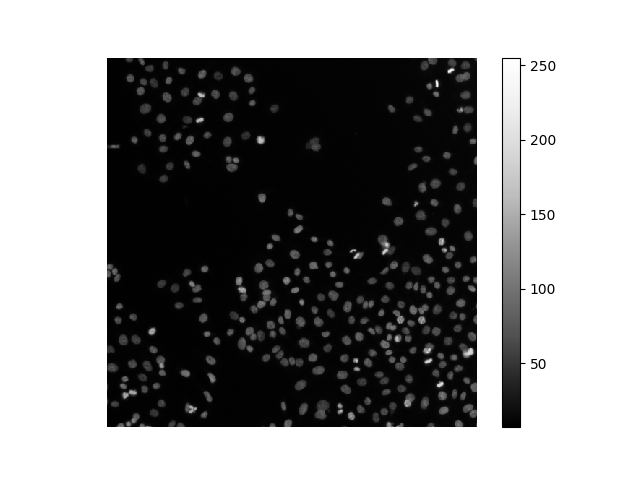
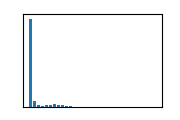

In [2]:
image = data.human_mitosis()

stackview.insight(image)

As we are looking at mitotic cells, we can formulate some interesting hypotheses:

__Hypothesis 1:__ The mitotic phase can be characterized using intensity-, size- and shape-based measurements.

__Hypothesis 2:__ The number of neighboring cells that are in the same phase of mitosis is higher in certain regions of the image, indicating a spatial correlation between cell cycle progression.

## Part 4) Cleaning the data

As we are looking at an image here, we need to perform some preprocessing as well as segmentation for feature extraction

StackViewNDArray([[0.03147407, 0.0312145 , 0.03101078, ..., 0.23563382,
                   0.27485459, 0.28743902],
                  [0.03201622, 0.03138104, 0.03090503, ..., 0.22507952,
                   0.26146368, 0.27447849],
                  [0.03279859, 0.03211894, 0.03160971, ..., 0.20237295,
                   0.24003942, 0.25731509],
                  ...,
                  [0.03189504, 0.03200721, 0.03150998, ..., 0.07650608,
                   0.1202781 , 0.17720847],
                  [0.03161322, 0.0317396 , 0.03148758, ..., 0.07409934,
                   0.11242074, 0.16363831],
                  [0.0314237 , 0.03144408, 0.03127161, ..., 0.07003586,
                   0.0999463 , 0.14088554]])
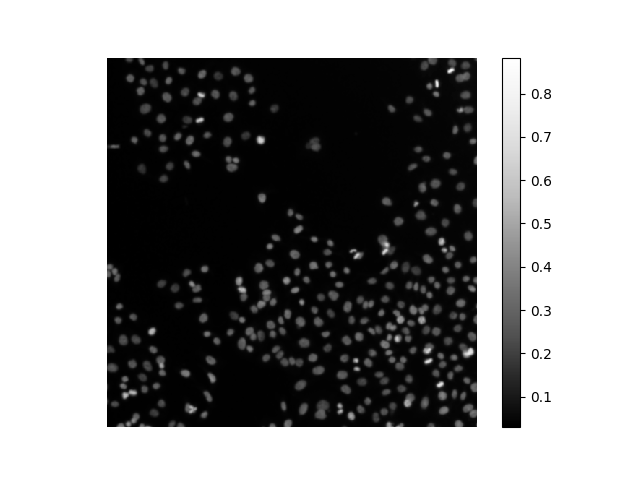
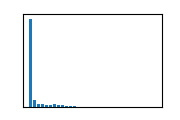

In [3]:
# Gaussian blur
image_gaussian = gaussian(image, sigma=1)
stackview.insight(image_gaussian)

_static_view.py (101): Converting input from bool to <class 'numpy.uint8'> for compatibility.


StackViewNDArray([[False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  [False, False, False, ...,  True,  True,  True],
                  ...,
                  [False, False, False, ..., False, False,  True],
                  [False, False, False, ..., False, False,  True],
                  [False, False, False, ..., False, False, False]])
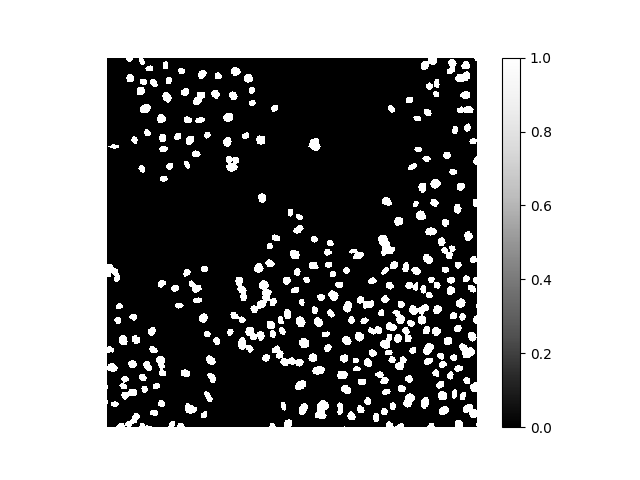
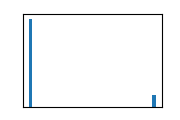

In [4]:
#threshold otsu
thresh = threshold_otsu(image_gaussian)
image_binary = image_gaussian > thresh
stackview.insight(image_binary)

StackViewNDArray([[  0,   0,   0, ...,   5,   5,   5],
                  [  0,   0,   0, ...,   5,   5,   5],
                  [  0,   0,   0, ...,   5,   5,   5],
                  ...,
                  [  0,   0,   0, ...,   0,   0, 275],
                  [  0,   0,   0, ...,   0,   0, 275],
                  [  0,   0,   0, ...,   0,   0,   0]], dtype=int32)
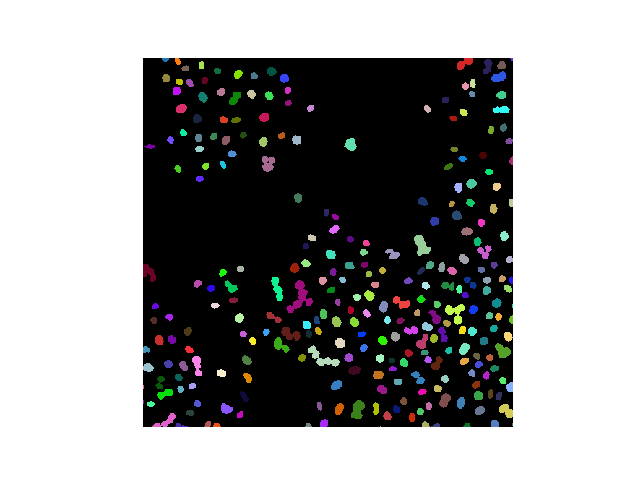

In [5]:
# Voronoi Otsu Labeling
img_labeled = label(image_binary)
stackview.insight(img_labeled)


Many dense nuclei are merged, so let us try out stardist here.

In [6]:
# Load a pre-trained 2D model (Versatile Fluorescent Nuclei)
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Run prediction
labels, _ = model.predict_instances(image_gaussian)

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.


functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 512, 512, 1))


Instead of visualizing the image with the labels side-by-side, let us try to use a curtain:

In [7]:
stackview.curtain(image, labels)

This looks way better!

In [9]:
properties = regionprops(labels, intensity_image=image)

In [ ]:
statistics = {
    'area':       [p.area               for p in properties],
    'mean':       [p.mean_intensity     for p in properties],
    'min':        [p.min_intensity      for p in properties],
    'max':        [p.max_intensity      for p in properties],
    'major_axis': [p.major_axis_length  for p in properties],
    'minor_axis': [p.minor_axis_length for p in properties],
    'centroid':   [p.centroid for p in properties],
    'coords':     [p.coords for p in properties],
    'eccentricity': [p.eccentricity for p in properties],
    'solidity': [p.solidity for p in properties],
    'extent': [p.extent for p in properties],
    'perimeter': [p.perimeter for p in properties],
    'equivalent_diameter': [p.equivalent_diameter for p in properties],
}

df = pd.DataFrame(statistics)

# Add new columns interesting for determining mitotic phases
df['condensation_ratio'] = df['max'] / df['mean']

# View the updated DataFrame
df.head()

,area,mean,min,max,major_axis,minor_axis,centroid,coords,eccentricity,solidity,extent,perimeter,equivalent_diameter,condensation_ratio
0,101.0,122.108911,48.0,162.0,12.032226,10.737512,"(114.42574257425743, 211.990099009901)","[[109, 211], [109, 212], [110, 208], [110, 209...",0.451253,0.935185,0.765152,35.556349,11.340070,1.326685
1,122.0,79.008197,41.0,116.0,13.078726,11.861871,"(468.1639344262295, 463.5245901639344)","[[462, 462], [462, 463], [462, 464], [463, 460...",0.421219,0.960630,0.782051,38.384776,12.463355,1.468202
2,163.0,56.484663,17.0,82.0,15.988471,13.014338,"(366.1042944785276, 291.9447852760736)","[[359, 289], [359, 290], [359, 291], [359, 292...",0.580889,0.958824,0.724444,45.455844,14.406181,1.451722
3,126.0,68.761905,27.0,94.0,13.241216,12.144300,"(386.76190476190476, 348.3174603174603)","[[381, 345], [381, 346], [381, 347], [381, 348...",0.398522,0.954545,0.807692,39.556349,12.666025,1.367036
4,134.0,62.201493,23.0,85.0,13.938847,12.235981,"(415.6194029850746, 284.5)","[[410, 282], [410, 283], [410, 284], [410, 285...",0.478967,0.964029,0.797619,40.384776,13.061933,1.366527


## Part 5) Fundamental Exploration

### Clustering

For data exploration, we can use an interactive UMAP which is a feature within the stackview package.

In [20]:
# Step 1: Select the features for UMAP
# Let's exclude 'coords' because it's variable-length and not numeric-flat
feature_columns = ['area', 'mean', 'min', 'max', 
                   'major_axis', 'minor_axis', 
                   'eccentricity', 'solidity', 
                   'extent', 'perimeter', 'equivalent_diameter', 
                   'condensation_ratio']

X = df[feature_columns].to_numpy()

# Step 2: Fit UMAP
reducer = umap.UMAP(random_state=42)
embedding = reducer.fit_transform(X)  # shape (n_samples, 2)

# Step 3: Add UMAP columns
df['UMAP_0'] = embedding[:, 0]
df['UMAP_1'] = embedding[:, 1]

deprecation.py (151): 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
umap_.py (1952): n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.


In [21]:
stackview.clusterplot(image = image,
                      labels = labels,
                      df = df,
                      column_x = 'UMAP_0',
                      column_y = 'UMAP_1',
                      zoom_factor = 1.6,
                      alpha = 0.7)

We can see that there are diffeent clusters in the UMAP plot corresponding to different morphologies of the nuclei. Let us dive deeper into the different numerical measurements in our dataset. Note that you can also select in the drop-down other measurements to explore how they relate.

### Numerical measurements

In [24]:
# Define numerical columns to analyze
numerical_columns = [
    'area', 'mean', 'min', 'max',
    'major_axis', 'minor_axis',
    'eccentricity', 'solidity', 'extent',
    'perimeter', 'equivalent_diameter', 'condensation_ratio'
]

# Create a summary DataFrame
summary_stats = []

for col in numerical_columns:
    min_val = df[col].min()
    max_val = df[col].max()
    mean_val = df[col].mean()
    std_val = df[col].std()
    idx_min = df[col].idxmin()
    idx_max = df[col].idxmax()
    
    summary_stats.append({
        'Feature': col,
        'Min': min_val,
        'Min Index': idx_min,
        'Max': max_val,
        'Max Index': idx_max,
        'Mean': mean_val,
        'Std Dev': std_val
    })

summary_df = pd.DataFrame(summary_stats)
summary_df

,Feature,Min,Min Index,Max,Max Index,Mean,Std Dev
0,area,47.000000,306,223.000000,89,102.621019,30.976127
1,mean,33.607843,312,143.886957,208,63.561148,17.798628
2,min,15.000000,262,50.000000,250,25.140127,5.635305
3,max,41.000000,312,255.000000,263,91.777070,30.882670
4,major_axis,8.188140,307,21.975378,151,12.776660,2.146304
5,minor_axis,5.702378,311,14.998784,89,10.079429,1.583758
6,eccentricity,0.168806,32,0.912362,311,0.580673,0.135477
7,solidity,0.804878,309,0.989899,310,0.946342,0.020603
8,extent,0.588235,253,0.888889,287,0.758746,0.045398
9,perimeter,23.899495,228,55.455844,151,35.544241,5.687245


2691132675.py (11): More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


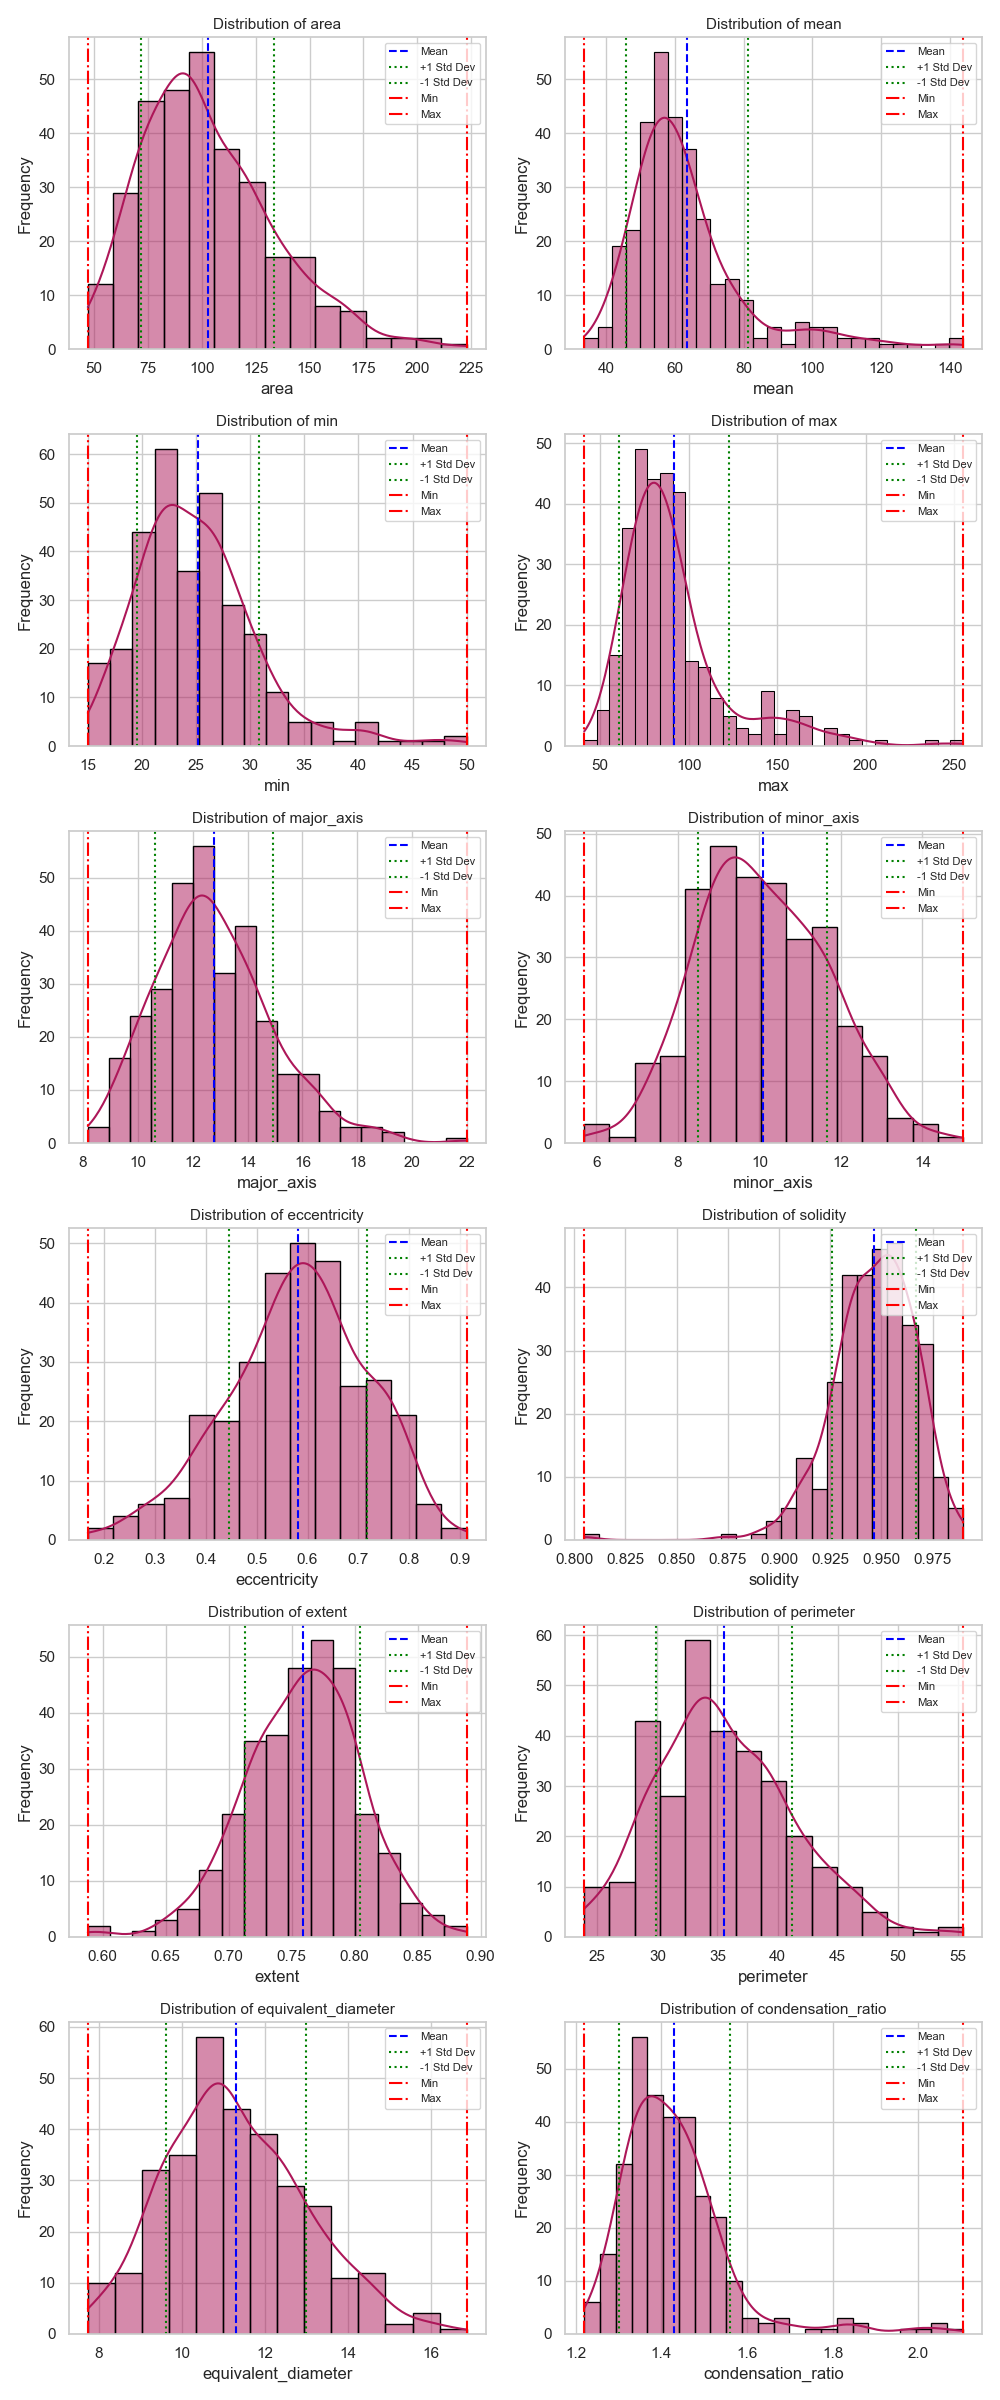

In [29]:
# Set Seaborn style and color palette
sns.set(style='whitegrid')
rocket_palette = sns.color_palette('rocket')
highlight_color = rocket_palette[2]

# Number of plots per row
cols = 2
rows = int(np.ceil(len(numerical_columns) / cols))

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(numerical_columns):
    ax = axes[i]
    sns.histplot(df[col], kde=True, color=highlight_color, edgecolor='black', ax=ax)
    
    # Calculate stats
    mean = df[col].mean()
    std = df[col].std()
    min_val = df[col].min()
    max_val = df[col].max()
    
    # Add vertical lines for mean, std, min, max
    ax.axvline(mean, color='blue', linestyle='--', label='Mean')
    ax.axvline(mean + std, color='green', linestyle=':', label='+1 Std Dev')
    ax.axvline(mean - std, color='green', linestyle=':', label='-1 Std Dev')
    ax.axvline(min_val, color='red', linestyle='-.', label='Min')
    ax.axvline(max_val, color='red', linestyle='-.', label='Max')

    ax.set_title(f"Distribution of {col}", fontsize=11)
    ax.set_xlabel(col)
    ax.set_ylabel("Frequency")
    ax.legend(fontsize=8, loc='upper right')

# Remove empty subplots (if any)
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Interesting to see the overall distribution of the features, but it is also a bit overwhelming. Maybe we can look at the correlation matrix to figure out feature correlation.

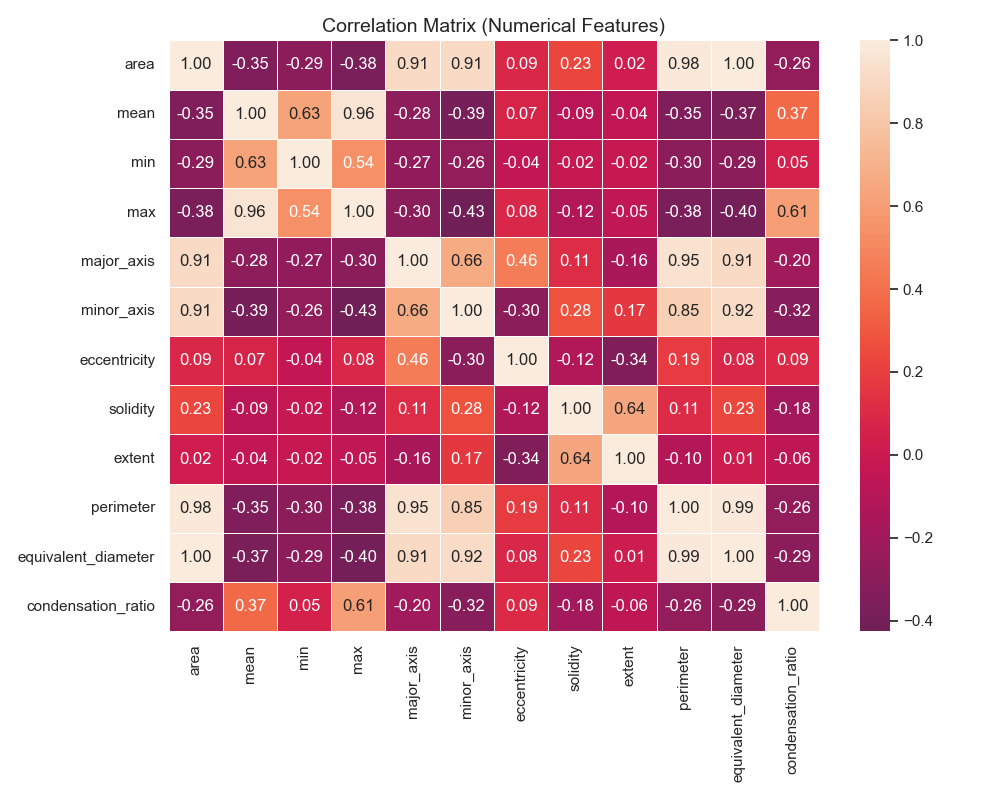

In [33]:
plt.figure(figsize=(10, 8))
corr = df[numerical_columns].corr()
sns.heatmap(corr, annot=True, cmap='rocket', center=0, fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix (Numerical Features)", fontsize=14)
plt.tight_layout()
plt.show()

Here, we can see nicely that size-based measurements like `area` correlate higher to other size-based measurements like `equivalent_diameter` or `major_axis` than to shape- or intensity-based measurements. This can also be seen in the other categories. If you want to find out more about how to group measurements into these categories, you can have a look at this [blog post](https://focalplane.biologists.com/2023/05/03/feature-extraction-in-napari/) I wrote some time ago.

## Part 6) Visualization

### Categorical: Mitotic Phase Classification

As this dataset does not have a time component, let us try to classify mitotic phases using intensity-, shape- and size-based measurements. Specifically, let us select four biologically relevant features: area, eccentricity, condensation ratio, and solidity. These features are known to change during the progression of mitosis as the nucleus condenses, elongates, and eventually divides.

In [43]:
# Select features for clustering
features = ['area', 'eccentricity', 'condensation_ratio', 'solidity']
X = df[features]

# Cluster into 4 groups
kmeans = KMeans(n_clusters=4, random_state=42)
df['predicted_phase'] = kmeans.fit_predict(X)

# Inspect the cluster centers to guide biological relabeling
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=features)
print("\nCluster Centers:\n", centroids)


Cluster Centers:
          area  eccentricity  condensation_ratio  solidity
0   95.043478      0.573187            1.413551  0.943508
1  125.500000      0.575450            1.397132  0.951818
2  168.785714      0.630123            1.408825  0.953877
3   69.252874      0.579699            1.491900  0.942376


Let us use the KMeans cluster centroids to assign each cluster to a biological mitotic phase. By inspecting the values of area, eccentricity, condensation_ratio, and solidity, we can infer the most likely phase represented by each cluster:

- Cluster 3 shows the highest condensation ratio and the smallest area, which strongly suggests **metaphase**, where chromosomes are maximally condensed and aligned.
- Cluster 0 has intermediate values for area and condensation ratio, which corresponds well to **prophase**, when chromatin begins to condense.
- Cluster 1 shows higher solidity and intermediate area, which fits **telophase**, where chromatin is de-condensing and nuclei are reforming.
- Cluster 2 has the largest area and the highest eccentricity, consistent with **anaphase**, when the chromatin is stretched as chromatids separate.

Based on this reasoning, we mapped:
- Cluster 0 → prophase  
- Cluster 1 → telophase  
- Cluster 2 → anaphase  
- Cluster 3 → metaphase

Since the relationship between these features is not strictly linear or sequential, a pair plot is a suitable visualization method. It allows us to examine pairwise distributions and interactions between multiple variables simultaneously while also visualizing how these relationships differ across the predicted mitotic phases. This enables the identification of clusters, trends, or overlaps in feature space that correspond to different biological states. By color-coding points according to the predicted phase, we can visually assess how well the features separate the phases and identify which combinations provide the clearest differentiation.

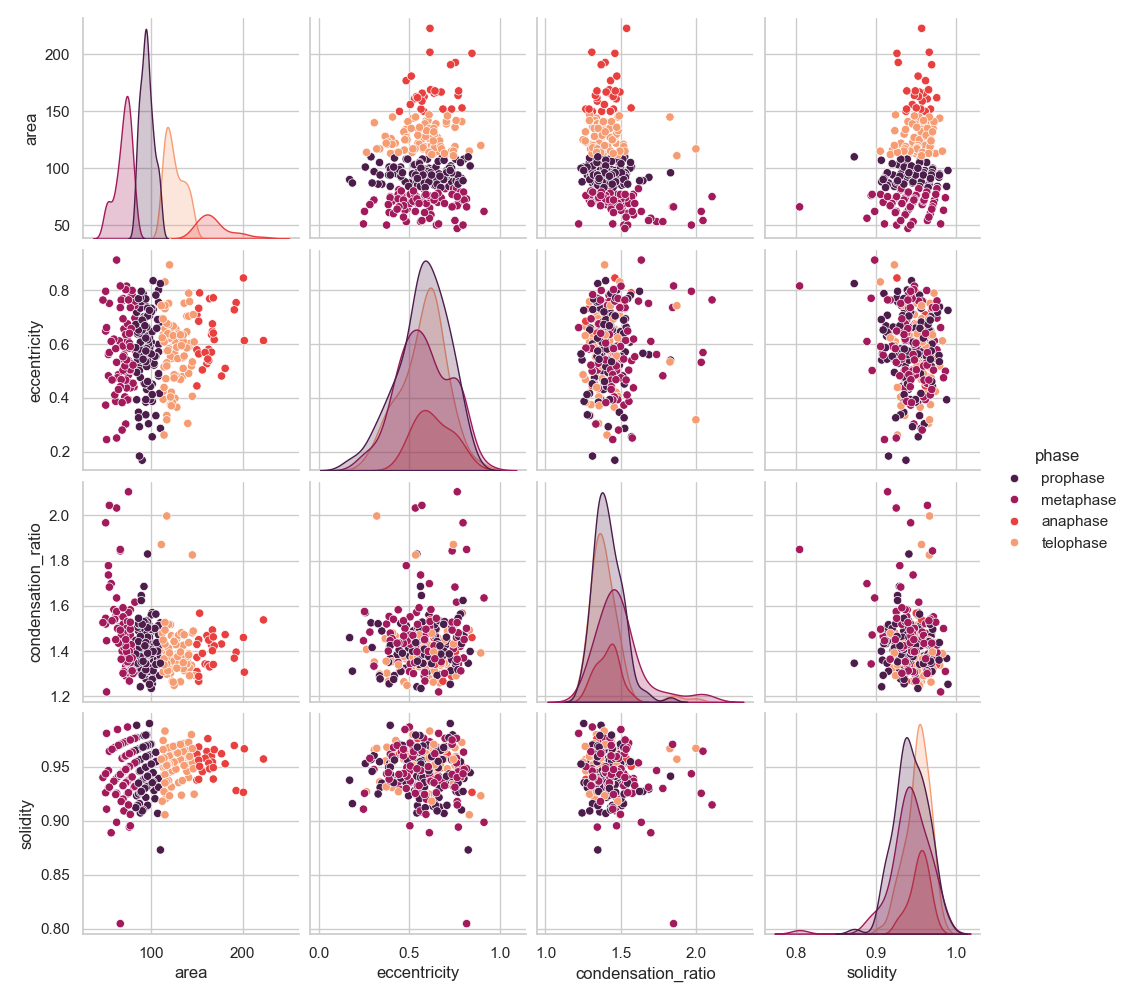

In [46]:
# Apply biological label mapping based on actual centroid values
corrected_map = {
    0: 'prophase',
    1: 'telophase',
    2: 'anaphase',
    3: 'metaphase'
}
df['phase'] = df['predicted_phase'].map(corrected_map)

# Define the biological order explicitly
phase_order = ['prophase', 'metaphase', 'anaphase', 'telophase']
df['phase'] = pd.Categorical(df['phase'], categories=phase_order, ordered=True)

# Create a new DataFrame with labeled phases
plot_df = df[features + ['phase']]

# Use the same color palette and plot
sns.pairplot(plot_df, hue='phase', vars=features, palette='rocket', hue_order=phase_order)
plt.show()

As our new category `phase` is categorical, we can plot how often each category occurs in the dataset.

1992866191.py (6): 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.



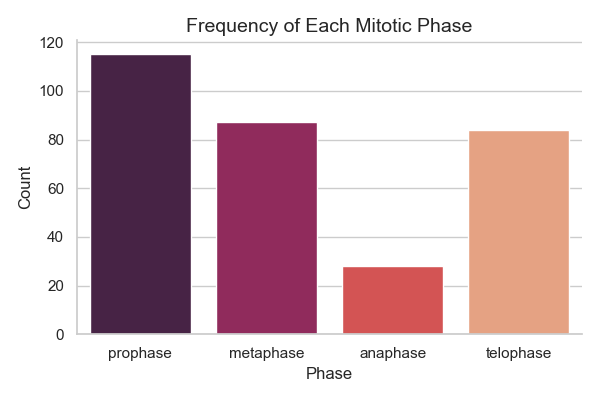

In [47]:
# Count occurrences of each phase
phase_counts = df['phase'].value_counts().reindex(phase_order)

# Plot the counts
plt.figure(figsize=(6, 4))
sns.barplot(x=phase_counts.index, y=phase_counts.values, palette='rocket')

# Title and labels
plt.title('Frequency of Each Mitotic Phase', fontsize=14)
plt.xlabel('Phase', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Optional cleanup
sns.despine()  # removes the top and right border
plt.tight_layout()  # adjusts spacing to avoid overflow
plt.show()

Now, it would still be very interesting to see the spatial distribution of the different phases. Therefore, we map our original image as well as a label image with the four phases next to each other.

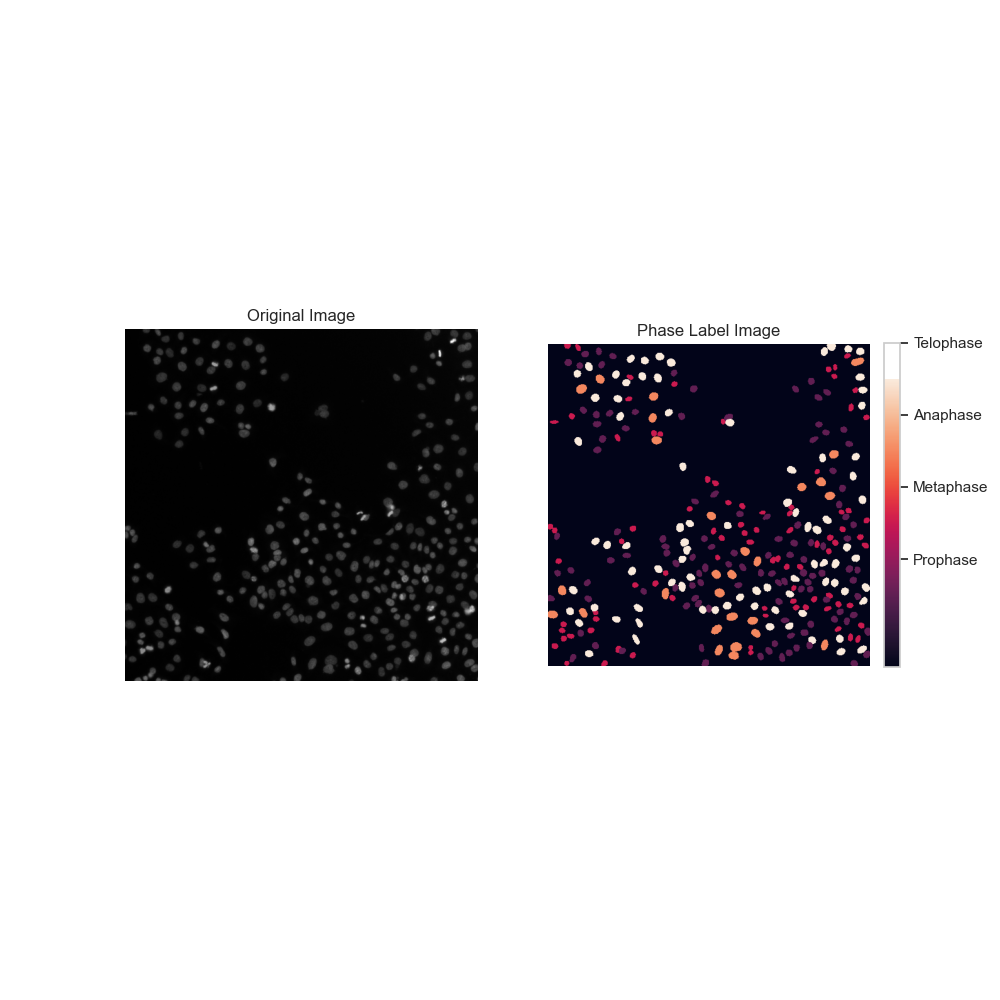

In [48]:
# Create a label image for visualization
phase_label_image = np.zeros_like(labels, dtype=np.int32)

# Map each region's phase label to the corresponding pixels in the label image
for region, phase_label in zip(properties, df['phase'].cat.codes):
    phase_label_image[tuple(region.coords.T)] = phase_label + 1  # Add 1 to avoid 0 for background

# Create a figure with two subplots
fig, ax = plt.subplots(1, 2, figsize=(10, 10))

# Show the original image on the left
ax[0].imshow(image, cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# Show the phase label image on the right with the 'rocket' colormap
im = ax[1].imshow(phase_label_image, cmap='rocket')
ax[1].set_title('Phase Label Image')
ax[1].axis('off')

# Add a colorbar with phase labels
cbar = fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04)
cbar.set_ticks([1.5, 2.5, 3.5, 4.5])
cbar.set_ticklabels(['Prophase', 'Metaphase', 'Anaphase', 'Telophase'])
cbar.set_label('Phase', rotation=270, labelpad=15)
plt.show()

This looks biologically reasonable, even though some labels could be swapped, especially between pro- and metaphase as well as ana- and telophase. 

## Part 7) Bonus: Highlight

Find a section in your data set with notable features (like strong derivations, extreme values, suspicious corelations, …).
Characterize those sections verbally and by statistical means and visualize the notable features.
Use a different kinds of visualization to explain the observed features.

_imshow.py (35): cle.imshow is deprecated, use stackview.imshow instead.


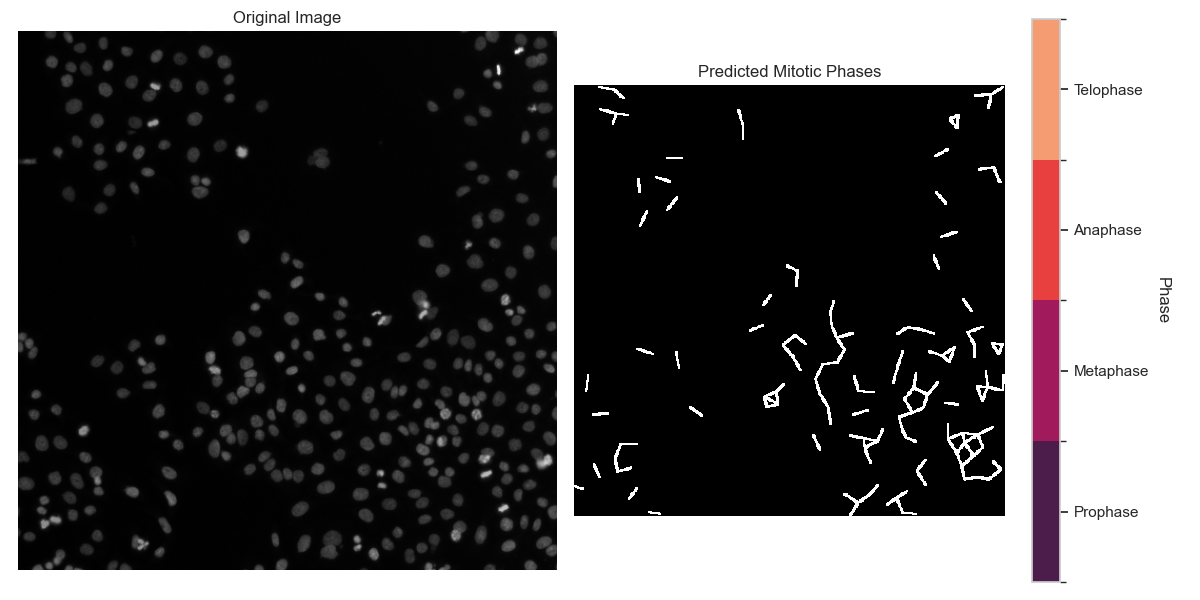

In [52]:
max_distance = 20

proximal_neighbor_mesh = cle.draw_mesh_between_proximal_labels(img_labeled, maximum_distance=max_distance)

# we make the lines a bit thicker for visualization purposes
proximal_neighbor_mesh = cle.maximum_box(proximal_neighbor_mesh, radius_x=1, radius_y=1)

cle.imshow(proximal_neighbor_mesh)